In [1]:
# Cell 1 — Imports & config
import os
import cv2
import numpy as np
import pywt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# CONFIG — edit these paths to match your machine
DATA_ROOT = r"D:\Infosys_AI-Tracefinder\Data"   # root folder containing Official/ Wikipedia/ Flatfield
DATASET_OFFICIAL   = os.path.join(DATA_ROOT, "Official")
DATASET_WIKIPEDIA  = os.path.join(DATA_ROOT, "Wikipedia")
DATASET_FLATFIELD  = os.path.join(DATA_ROOT, "Flatfield")   # NEW

# optional: directory to save generated wikipedia residuals (.npy) — set to None to disable saving
WIKI_RES_SAVE_DIR = None # set to None to skip saving

IMG_SIZE = (256, 256)
BATCH_SIZE = 16
EPOCHS = 20
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.20.0


In [2]:
# Cell 2 — helper image / residual functions (mentor-style)
img_size = IMG_SIZE

def to_grey(img):
    # accept grayscale or color; ensure 2D
    if img is None:
        return None
    if len(img.shape) == 3:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def resize_to(img, size=img_size):
    # size expected (w,h) in our usage below we pass (256,256)
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

def normalize_img(img):
    # returns float32 scaled 0..1
    imgf = img.astype(np.float32)
    # handle 16-bit tiffs too
    maxv = float(imgf.max()) if imgf.max() > 0 else 255.0
    return imgf / maxv

def denoise_wavelet(img):
    # single-level 2D DWT Haar, zero high-frequency coeffs, inverse
    # img expected float32
    coeffs = pywt.dwt2(img, "haar")
    cA, (cH, cV, cD) = coeffs
    # remove high-frequency details (approximate denoising)
    cH[:] = 0
    cV[:] = 0
    cD[:] = 0
    rec = pywt.idwt2((cA, (cH, cV, cD)), 'haar')
    # idwt2 may return slightly different shape; ensure same shape
    if rec.shape != img.shape:
        # resize returns (h,w) if called with size=(w,h) so be careful
        rec = cv2.resize(rec, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_AREA)
    return rec

def compute_residual_from_tiff(path):
    # read tiff in original bit depth, convert to grayscale/resized/normalized
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        return None
    g = to_grey(img)
    g = cv2.resize(g, (img_size[0], img_size[1]), interpolation=cv2.INTER_AREA)
    g = normalize_img(g)
    den = denoise_wavelet(g)
    # residual: original - denoised (float32)
    res = (g - den).astype(np.float32)
    # normalize residual to range [-1,1] by max abs to make training stable
    m = np.max(np.abs(res)) if np.max(np.abs(res)) > 0 else 1.0
    res = res / m
    # reshape channel-last for CNN
    return res.reshape(img_size[0], img_size[1], 1)


In [3]:
# Cell 3 — dataset loader (official + wikipedia + flatfield)
def load_from_folder(root_path, save_npy=False, save_dir=None, dataset_type="scanners"):
    """
    root_path structure:
      - Official / Wikipedia: scanner_name / dpi / *.tif
      - Flatfield: scanner_name / 150.tif, 300.tif (files directly under scanner folder)
    dataset_type is just a friendly name for tqdm labels.
    """
    X = []
    y = []
    scanners = sorted([d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))])
    for scanner in scanners:
        scanner_dir = os.path.join(root_path, scanner)
        # find dpi-subdirs
        dpi_dirs = sorted([d for d in os.listdir(scanner_dir) if os.path.isdir(os.path.join(scanner_dir, d))])
        if len(dpi_dirs) > 0:
            # standard case: scanner/dpi/*.tif
            for dpi in dpi_dirs:
                dpi_path = os.path.join(scanner_dir, dpi)
                files = [f for f in os.listdir(dpi_path) if f.lower().endswith(('.tif', '.tiff')) and not f.startswith("._")]
                for f in tqdm(files, desc=f"{dataset_type}:{scanner}/{dpi}", leave=False):
                    fpath = os.path.join(dpi_path, f)
                    res = compute_residual_from_tiff(fpath)
                    if res is None:
                        continue
                    X.append(res)
                    y.append(scanner)
        else:
            # flatfield-style: files directly in scanner folder
            files = [f for f in os.listdir(scanner_dir) if f.lower().endswith(('.tif', '.tiff')) and not f.startswith("._")]
            for f in tqdm(files, desc=f"{dataset_type}:{scanner}", leave=False):
                fpath = os.path.join(scanner_dir, f)
                res = compute_residual_from_tiff(fpath)
                if res is None:
                    continue
                X.append(res)
                y.append(scanner)

    X = np.array(X, dtype=np.float32) if len(X) > 0 else np.zeros((0, img_size[0], img_size[1], 1), dtype=np.float32)
    y = np.array(y, dtype=object)
    # optional save per-dataset npy
    if save_npy and save_dir is not None and X.shape[0] > 0:
        os.makedirs(save_dir, exist_ok=True)
        base = os.path.basename(os.path.normpath(root_path))
        np.save(os.path.join(save_dir, f"{base}_X.npy"), X)
        np.save(os.path.join(save_dir, f"{base}_y.npy"), y)
        print(f"Saved: {os.path.join(save_dir, f'{base}_X.npy')}")
    return X, y

# load Official
print("🔄 Loading Official residuals (compute from TIFFs)...")
X_off, y_off = load_from_folder(DATASET_OFFICIAL, save_npy=False, dataset_type="Official")

# load Wikipedia
print("🔄 Loading Wikipedia residuals (compute from TIFFs)...")
X_wiki, y_wiki = load_from_folder(DATASET_WIKIPEDIA, save_npy=(WIKI_RES_SAVE_DIR is not None), save_dir=WIKI_RES_SAVE_DIR, dataset_type="Wikipedia")

# load Flatfield (NEW)
print("🔄 Loading Flatfield residuals (compute from TIFFs)...")
X_flat, y_flat = load_from_folder(DATASET_FLATFIELD, save_npy=False, dataset_type="Flatfield")

# combine (handle empty arrays safely)
X_list = [arr for arr in [X_off, X_wiki, X_flat] if arr is not None and len(arr) > 0]
y_list = [arr for arr in [y_off, y_wiki, y_flat] if arr is not None and len(arr) > 0]

if len(X_list) == 0:
    raise RuntimeError("No data loaded from any dataset. Check dataset paths and files.")

X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)

print("Shapes -> X:", X.shape, "y:", y.shape)


🔄 Loading Official residuals (compute from TIFFs)...


🔄 Loading Wikipedia residuals (compute from TIFFs)...


🔄 Loading Flatfield residuals (compute from TIFFs)...


Shapes -> X: (4589, 256, 256, 1) y: (4589,)


In [4]:
# Cell 4 — label encode and train/test split
le = LabelEncoder()
y_enc = le.fit_transform(y)
num_classes = len(le.classes_)
print("Classes:", le.classes_)

# stratified split to test set, keep validation during fit (validation_split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.15, random_state=RANDOM_STATE, stratify=y_enc, shuffle=True
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Classes: ['Canon120-1' 'Canon120-2' 'Canon220' 'Canon9000-1' 'Canon9000-2'
 'EpsonV370-1' 'EpsonV370-2' 'EpsonV39-1' 'EpsonV39-2' 'EpsonV550' 'HP']
Train: (3900, 256, 256, 1) Test: (689, 256, 256, 1)


In [5]:
# Cell 5 — model (mentor-style but slightly improved)
def build_mentor_cnn(input_shape=(256,256,1), num_classes=11):
    model = models.Sequential([
        keras.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        layers.MaxPool2D(2),

        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.MaxPool2D(2),

        layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        layers.MaxPool2D(2),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation="softmax")
    ])
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

model = build_mentor_cnn(input_shape=X_train.shape[1:], num_classes=num_classes)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,871,435 (64.36 MB)

 Trainable params: 16,871,435 (64.36 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Cell 6 — training (callbacks, fit)
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    keras.callbacks.ModelCheckpoint("mentor_cnn_best.keras", save_best_only=True, monitor='val_accuracy')
]

history = model.fit(
    X_train, y_train,
    validation_split=0.2,   # keep part of train as validation
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/20
195/195 - 90s - 460ms/step - accuracy: 0.2628 - loss: 2.0452 - val_accuracy: 0.4410 - val_loss: 1.5861 - learning_rate: 1.0000e-04
Epoch 2/20
195/195 - 94s - 483ms/step - accuracy: 0.5218 - loss: 1.3133 - val_accuracy: 0.5987 - val_loss: 1.0940 - learning_rate: 1.0000e-04
Epoch 3/20
195/195 - 96s - 490ms/step - accuracy: 0.6699 - loss: 0.8828 - val_accuracy: 0.6577 - val_loss: 0.8697 - learning_rate: 1.0000e-04
Epoch 4/20
195/195 - 95s - 489ms/step - accuracy: 0.7673 - loss: 0.6164 - val_accuracy: 0.7321 - val_loss: 0.6673 - learning_rate: 1.0000e-04
Epoch 5/20
195/195 - 92s - 473ms/step - accuracy: 0.8138 - loss: 0.4848 - val_accuracy: 0.7731 - val_loss: 0.5712 - learning_rate: 1.0000e-04
Epoch 6/20
195/195 - 148s - 758ms/step - accuracy: 0.8535 - loss: 0.3854 - val_accuracy: 0.7910 - val_loss: 0.5449 - learning_rate: 1.0000e-04
Epoch 7/20
195/195 - 96s - 494ms/step - accuracy: 0.8875 - loss: 0.3083 - val_accuracy: 0.8103 - val_loss: 0.5569 - learning_rate: 1.0000e-04
Epoch

In [7]:
# Cell 7 — evaluate & classification report
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

preds = model.predict(X_test)
pred_labels = np.argmax(preds, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, pred_labels, target_names=le.classes_, zero_division=0))


Test Accuracy: 0.9318
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step

Classification Report:
              precision    recall  f1-score   support

  Canon120-1       0.83      0.86      0.84        63
  Canon120-2       0.82      0.76      0.79        62
    Canon220       0.94      0.97      0.95        63
 Canon9000-1       0.91      0.94      0.92        63
 Canon9000-2       0.92      0.92      0.92        61
 EpsonV370-1       1.00      0.97      0.98        63
 EpsonV370-2       0.97      0.98      0.98        63
  EpsonV39-1       0.94      0.95      0.94        63
  EpsonV39-2       0.95      0.92      0.94        63
   EpsonV550       0.98      0.98      0.98        62
          HP       0.98      1.00      0.99        63

    accuracy                           0.93       689
   macro avg       0.93      0.93      0.93       689
weighted avg       0.93      0.93      0.93       689



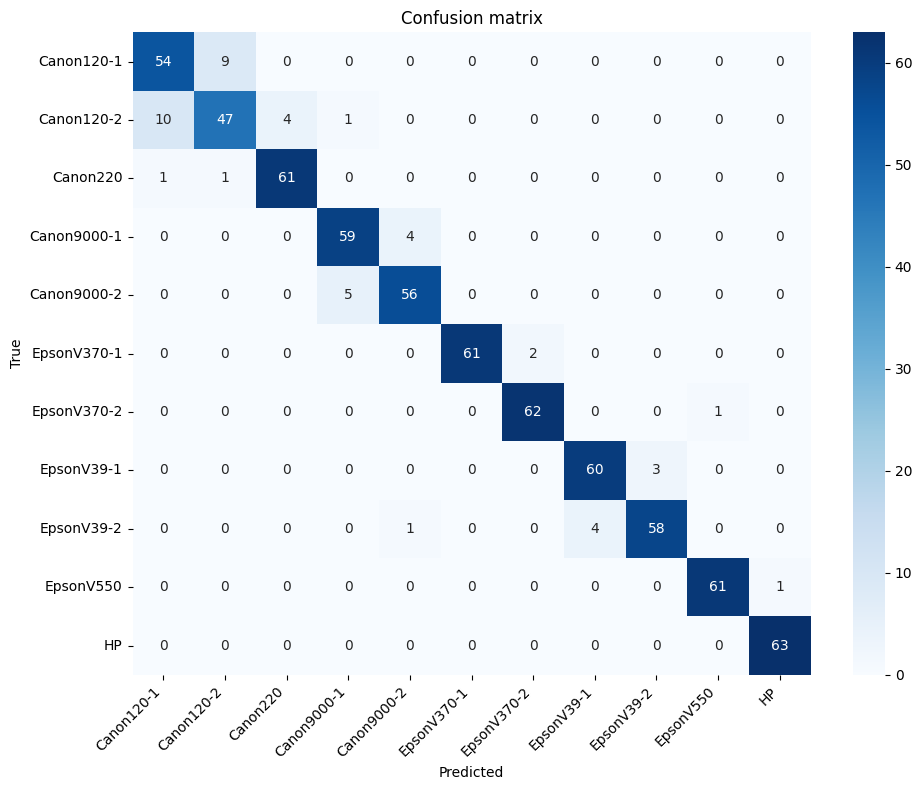

Saved model and label encoder.


In [8]:
# Cell 8 — confusion matrix visualization & save artifacts
cm = confusion_matrix(y_test, pred_labels)

plt.figure(figsize=(10,8))
import seaborn as sns
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# save model and label encoder
model.save("mentor_cnn_final.keras")
with open("mentor_cnn_label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)
print("Saved model and label encoder.")


In [9]:
# Cell 9 — single image predict helper
def predict_scanner(image_path, model=model, label_encoder=le):
    res = compute_residual_from_tiff(image_path)
    if res is None:
        return None, None
    res = res.reshape(1, img_size[0], img_size[1], 1)
    probs = model.predict(res)[0]
    idx = np.argmax(probs)
    label = label_encoder.inverse_transform([idx])[0]
    confidence = float(probs[idx])
    return label, confidence

# Example:
# label, conf = predict_scanner(r"D:\Infosys_AI-Tracefinder\Data\Flatfield\HP\150.tif")
# print(label, conf)


In [10]:
from tensorflow import keras
import tensorflow as tf

# Load your trained model
model = keras.models.load_model("cnn_residual_best.keras")

# Freeze all layers (no training allowed)
for layer in model.layers:
    layer.trainable = False

# Get the layer BEFORE final Dense classifier
feature_layer = model.get_layer(index=-3).output   # GlobalAveragePooling layer

# Build extractor model: input → feature vector
feature_extractor = keras.Model(
    inputs=model.input,
    outputs=feature_layer,
    name="frozen_cnn_feature_extractor"
)

# Save frozen model
feature_extractor.save("cnn_feature_extractor.keras")
print("Saved frozen feature extractor: cnn_feature_extractor.keras")

# Test
import numpy as np
dummy = np.zeros((1,256,256,1), dtype=np.float32)
vec = feature_extractor.predict(dummy)
print("Feature vector shape:", vec.shape)


Saved frozen feature extractor: cnn_feature_extractor.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Feature vector shape: (1, 128)


In [16]:
import cv2
import numpy as np
import pywt
import pickle                           
from tensorflow import keras

# ---------------------------
# Load frozen classifier model
# ---------------------------
cnn_model = keras.models.load_model("cnn_residual_best.keras")
label_encoder = pickle.load(open("cnn_label_encoder.pkl", "rb"))

# Warm-up to avoid retracing
cnn_model.predict(np.zeros((1,256,256,1), dtype=np.float32))

# ---------------------------
# Residual creation
# ---------------------------
def make_residual(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError("Could not read image.")
    
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = cv2.resize(img, (256,256)).astype(np.float32)
    img = img / (img.max() if img.max() > 0 else 1)

    # Wavelet denoise
    cA, (cH, cV, cD) = pywt.dwt2(img, "haar")
    cH[:] = cV[:] = cD[:] = 0
    den = pywt.idwt2((cA, (cH, cV, cD)), "haar")

    res = img - den
    m = np.max(np.abs(res)) or 1
    res = res / m

    return res.reshape(1,256,256,1).astype(np.float32)

# ---------------------------
# Predict scanner label
# ---------------------------
def predict_cnn(image_path):
    res = make_residual(image_path)
    prob = cnn_model.predict(res)[0]
    idx = np.argmax(prob)
    label = label_encoder.inverse_transform([idx])[0]
    return label, prob[idx]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


In [17]:
label, conf = predict_cnn(r"D:\Infosys_AI-Tracefinder\Data\Flatfield\HP\300.tif")
print(label, conf)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
HP 0.998509
